## Notebook Outlining How to Read/Process the Data

In [11]:
import wfdb
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt

import os

from wfdb import processing

from config import ARR_DATA_DIR, NSR_DATA_DIR

## Read in Different Datasets and Analyze Rhythms

### Arrythmia Dataset

In [ ]:
f = open(os.path.join(ARR_DATA_DIR, 'RECORDS'))
arrythmia_samples = [x.strip() for x in f.readlines()]

print(arrythmia_samples)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
2764
2764


In [12]:
all_labels = []

for samp in arrythmia_samples:
    annotation = wfdb.rdann('{}/{}'.format(ARR_DATA_DIR, samp), 'atr')
    all_labels += annotation.aux_note

all_labels = set(all_labels)

all_labels

{'',
 '(AB\x00',
 '(AFIB',
 '(AFIB\x00',
 '(AFL',
 '(AFL\x00',
 '(B\x00',
 '(BII\x00',
 '(IVR\x00',
 '(N',
 '(N\x00',
 '(NOD\x00',
 '(P\x00',
 '(PREX\x00',
 '(SBR\x00',
 '(SVTA',
 '(SVTA\x00',
 '(T\x00',
 '(VFL\x00',
 '(VT\x00',
 'MISSB\x00',
 'PSE\x00',
 'TS\x00'}

In [60]:
'''
Convert encodings (https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm#symbols) to 6 distinct classes
May want to reduce if the dataset is really unbalanced
- normal (N, SBR): 0
- afib (AFIB, ): 1
- other supraventricular arrhythmias (AB, AFL, NOD, SVTA): 2
- ventricular arrhythmias (B, IVR, T, VFL, VT): 3
- paced beats (P, PREX): 4
- heart block (B2, ): 5

Ignore segments with poor signal quality (MIISB, PSE, TS): -1
'''
LABEL_TO_ENCODING = {
    '(AB': 2,
    '(AFIB': 1,
    '(AFIB': 1,
    '(AFL': 2,
    '(B': 3,
    '(BII': 5,
    '(IVR': 3,
    '(N': 0,
    '(NOD': 2,
    '(P': 4,
    '(PREX': 4,
    '(SBR': 0,
    '(SVTA': 2,
    '(T': 3,
    '(VFL': 3,
    '(VT': 3,
    'MISSB': -1,
    'PSE': -1,
    'TS': -1, 
}

In [62]:
record = wfdb.rdrecord('{}/{}'.format(ARR_DATA_DIR, 106))
annotation = wfdb.rdann('{}/{}'.format(ARR_DATA_DIR, 106), 'atr')

raw_ecg = record.p_signal[:, 0]

print(annotation.record_name)
print(record.p_signal.shape)
print(record.fs)
print(annotation.__dict__.keys())
print(annotation.sample)
print(annotation.aux_note)
print(len(annotation.aux_note), len(annotation.sample))

106
(650000, 2)
360
dict_keys(['record_name', 'extension', 'sample', 'symbol', 'subtype', 'chan', 'num', 'aux_note', 'fs', 'label_store', 'description', 'custom_labels', 'contained_labels', 'ann_len'])
[    83    229    351 ... 649162 649340 649791]
['', '(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

In [ ]:
# Convert the Rhythm Annotation To Per-Sample (Beat) Annotation
aux_note = np.char.replace(np.array(annotation.aux_note, dtype=str), '\x00', '')
per_beat_rhythm_annotation = np.empty_like(aux_note)
start_indeces = np.where(aux_note != '')[0]
end_indeces = np.concatenate([np.where(aux_note != '')[0][1:], [len(aux_note)]])
rhythm_vals = aux_note[np.where(aux_note != '')]

for si, ei, ba in zip(start_indeces, end_indeces, rhythm_vals):
    per_beat_rhythm_annotation[si:ei] = ba

per_sample_rhythm_annotation = - np.ones_like(record.p_signal[:, 0])

start_indeces = annotation.sample
end_indeces = np.concatenate([annotation.sample[1:], [len(per_sample_rhythm_annotation)]])

for si, ei, ba in zip(start_indeces, end_indeces, per_beat_rhythm_annotation):
    per_sample_rhythm_annotation[si:ei] = LABEL_TO_ENCODING[ba]


['' '(N' '(N' ... '(N' '(N' '(N']


KeyError: np.str_('')

### NSR Dataset

In [18]:
f = open(os.path.join(NSR_DATA_DIR, 'RECORDS'))
nsr_samples = [x.strip() for x in f.readlines()]

print(nsr_samples)

['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']


In [19]:
all_labels = []

for samp in nsr_samples:
    annotation = wfdb.rdann('{}/{}'.format(NSR_DATA_DIR, samp), 'atr')
    all_labels += annotation.symbol

all_labels = set(all_labels)

all_labels

{'F', 'J', 'N', 'S', 'V', '|', '~'}

In [ ]:
'''
Convert beats (https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm#symbols) to normal or abnormal (for disregarding)
'''
LABEL_TO_ENCODING = {
    'F': -1, 
    'J': -1, 
    'N': 0, 
    'S': -1, 
    'V': -1, 
    '|': -1, 
    '~': -1
}

In [30]:
record = wfdb.rdrecord('{}/{}'.format(NSR_DATA_DIR, nsr_samples[2]))
annotation = wfdb.rdann('{}/{}'.format(NSR_DATA_DIR, nsr_samples[2]), 'atr')

raw_ecg = record.p_signal[:, 0]

print(annotation.record_name)
print(record.p_signal.shape)
print(record.fs)
print(annotation.__dict__.keys())
print(annotation.symbol)
print(len(annotation.symbol), len(annotation.sample))

16273
(11354112, 2)
128
dict_keys(['record_name', 'extension', 'sample', 'symbol', 'subtype', 'chan', 'num', 'aux_note', 'fs', 'label_store', 'description', 'custom_labels', 'contained_labels', 'ann_len'])
['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'

In [48]:
symbol_note = annotation.symbol

per_sample_beat_annotation = - np.ones_like(record.p_signal[:, 0])

start_indeces = annotation.sample
end_indeces = np.concatenate([annotation.sample[1:], [len(per_sample_beat_annotation)]])

for si, ei, ba in zip(start_indeces, end_indeces, symbol_note):
    per_sample_beat_annotation[si:ei] = LABEL_TO_ENCODING[ba]

## Read ARR Dataset and Analyze Beats

In [10]:
f = open(os.path.join(ARR_DATA_DIR, 'RECORDS'))
arrythmia_samples = [x.strip() for x in f.readlines()]

print(arrythmia_samples)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [13]:
all_labels = []

for samp in arrythmia_samples:
    annotation = wfdb.rdann('{}/{}'.format(ARR_DATA_DIR, samp), 'atr')
    all_labels += annotation.symbol

all_labels = set(all_labels)

all_labels

{'!',
 '"',
 '+',
 '/',
 'A',
 'E',
 'F',
 'J',
 'L',
 'N',
 'Q',
 'R',
 'S',
 'V',
 '[',
 ']',
 'a',
 'e',
 'f',
 'j',
 'x',
 '|',
 '~'}

In [15]:
# USE AAMI STANDARD TO CLASSIFY BEATS, IGNORE UNKNOWN/CERTAIN BEATS
BEAT_TO_ENCODING = {
    '!': -1,
    '"': -1,
    '+': -1,
    '/': -1,
    'A': 1,
    'E': 2,
    'F': 3,
    'J': 1,
    'L': 0,
    'N': 0,
    'Q': -1,
    'R': 0,
    'S': 1,
    'V': 2,
    '[': -1,
    ']': -1,
    'a': 1,
    'e': 0,
    'f': 0,
    'j': 0,
    'x': -1,
    '|': -1,
    '~': -1,
}

In [17]:
record = wfdb.rdrecord('{}/{}'.format(ARR_DATA_DIR, 106))
annotation = wfdb.rdann('{}/{}'.format(ARR_DATA_DIR, 106), 'atr')

raw_ecg = record.p_signal[:, 0]

print(annotation.record_name)
print(record.p_signal.shape)
print(record.fs)
print(annotation.__dict__.keys())
print(annotation.sample)
print(annotation.symbol)
print(len(annotation.symbol), len(annotation.sample))

106
(650000, 2)
360
dict_keys(['record_name', 'extension', 'sample', 'symbol', 'subtype', 'chan', 'num', 'aux_note', 'fs', 'label_store', 'description', 'custom_labels', 'contained_labels', 'ann_len'])
[    83    229    351 ... 649162 649340 649791]
['~', '+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '~', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '~', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '~', 'N', 'V', 'V', 'N', 'V', 'V', 'N', 'N', 'V', 'N', 'V', 'V', 'N', 'V', 'N', 'V', 'V', 'N', 'N', 'V', 'V', 'N', 'V', 'V', 'N', 'N', 'V', 'V', 'N', 'N', 'V', 'V', 'N', 'V', 'N', 'V', 'V', 'N', 'V', 'N', 'V', 'N', 'V', 'V',

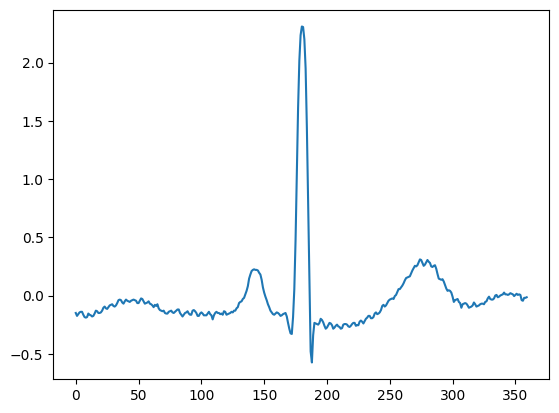

In [44]:
beat_encoding = np.array([BEAT_TO_ENCODING[x] for x in annotation.symbol])
beat_samples = np.array(annotation.sample)
mask = np.where(beat_encoding > -1)

filtered_encoding = beat_encoding[mask]
filtered_beats = beat_samples[mask]

window_len = 1 * record.fs
beat_windows = [(int(x - window_len // 2), int(x + window_len //2)) for x in filtered_beats]


plt.plot(raw_ecg[beat_windows[500][0]:beat_windows[500][1]])

## Read a Single ECG and Explore Filtering Options

In [55]:
record = wfdb.rdrecord('{}/{}'.format(NSR_DATA_DIR, nsr_samples[2]))
annotation = wfdb.rdann('{}/{}'.format(NSR_DATA_DIR, nsr_samples[2]), 'atr')

raw_ecg = record.p_signal[:, 0]

print(record.p_signal.shape)
print(record.fs)
print(annotation.__dict__)

(11354112, 2)
128
{'record_name': '16273', 'extension': 'atr', 'sample': array([      9,      87,     164, ..., 9516519, 9516612, 9516699],
      shape=(90097,)), 'symbol': ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

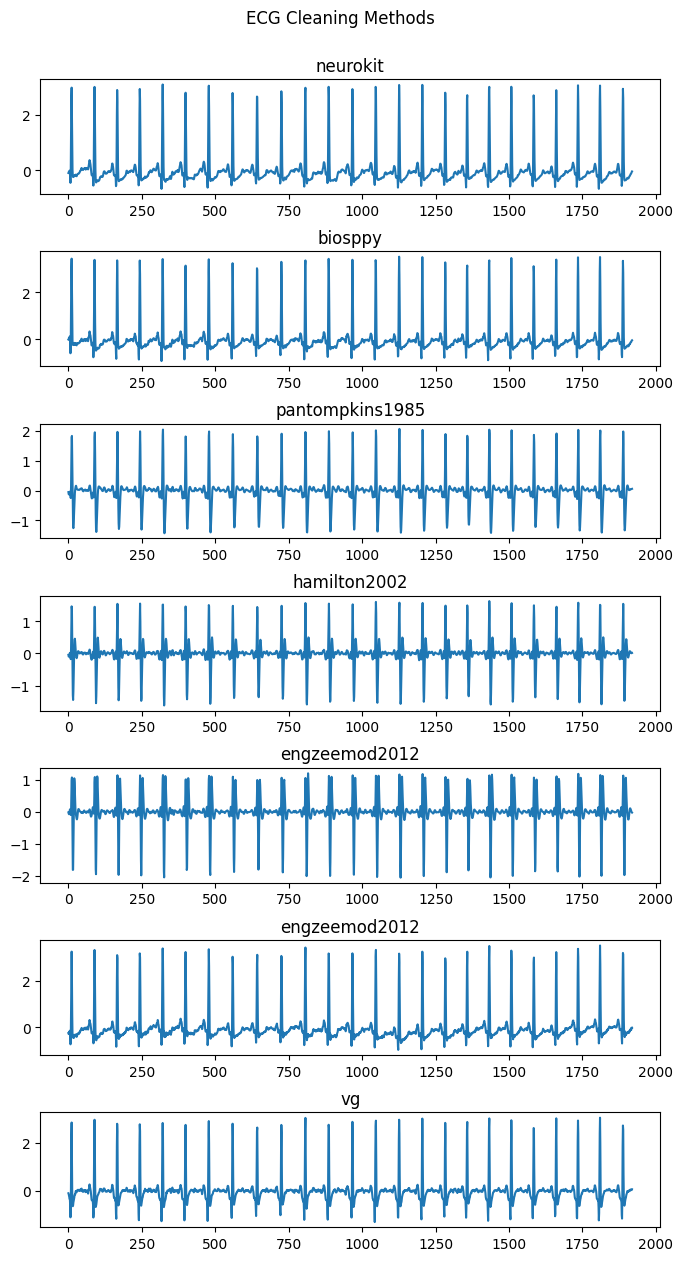

In [56]:
# https://neuropsychology.github.io/NeuroKit/functions/ecg.html

ecg_for_plotting = raw_ecg.copy()

fig, axes = plt.subplots(7, 1, figsize=(8, 14))

fig.suptitle('ECG Cleaning Methods')

filtered_signal = nk.ecg_clean(ecg_for_plotting, sampling_rate = record.fs, method='neurokit')
snippet = filtered_signal[0: 0 + record.fs * 15]
axes[0].plot(snippet)
axes[0].set_title('neurokit')

filtered_signal = nk.ecg_clean(ecg_for_plotting, sampling_rate = record.fs, method='biosppy')
snippet = filtered_signal[0: 0 + record.fs * 15]
axes[1].plot(snippet)
axes[1].set_title('biosppy')


filtered_signal = nk.ecg_clean(ecg_for_plotting, sampling_rate = record.fs, method='pantompkins1985')
snippet = filtered_signal[0: 0 + record.fs * 15]
axes[2].plot(snippet)
axes[2].set_title('pantompkins1985')


filtered_signal = nk.ecg_clean(ecg_for_plotting, sampling_rate = record.fs, method='hamilton2002')
snippet = filtered_signal[0: 0 + record.fs * 15]
axes[3].plot(snippet)
axes[3].set_title('hamilton2002')


filtered_signal = nk.ecg_clean(ecg_for_plotting, sampling_rate = record.fs, method='elgendi2010')
snippet = filtered_signal[0: 0 + record.fs * 15]
axes[4].plot(snippet)
axes[4].set_title('engzeemod2012')


filtered_signal = nk.ecg_clean(ecg_for_plotting, sampling_rate = record.fs, method='engzeemod2012')
snippet = filtered_signal[0: 0 + record.fs * 15]
axes[5].plot(snippet)
axes[5].set_title('engzeemod2012')


filtered_signal = nk.ecg_clean(ecg_for_plotting, sampling_rate = record.fs, method='vg')
snippet = filtered_signal[0: 0 + record.fs * 15]
axes[6].plot(snippet)
axes[6].set_title('vg')

fig.subplots_adjust(hspace=0.5, top=0.93)